In [1]:
import os
import skimage as ski
import watershed_udder as wu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyrealsense2 as rs
from astropy.convolution import Gaussian2DKernel, convolve,interpolate_replace_nans
import open3d as o3d
import plotly.graph_objects as go
import plotly.io as pio

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def points_toworld(points):
    points2 = points.copy()
    for i in range(len(points)):
        points2[i, :] = rs.rs2_deproject_pixel_to_point(intr, [points[i, 0], points[i, 1]], points[i, 2])
    return points2

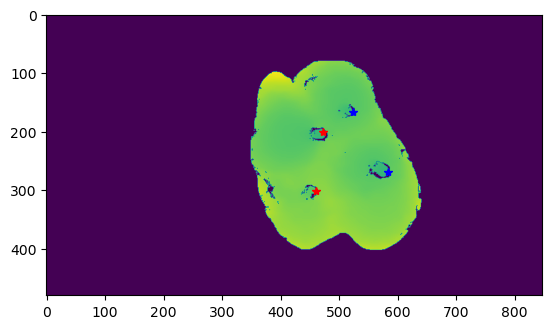

In [3]:
# list files 
dirpath = os.getcwd()
ws_dir = r"validate_watershed\watershed_segments"
corr_dir = r"validate_watershed\watershed_correspondence"
label_dir = os.path.join(dirpath, r"validate_watershed\pred_labels")
kp_dir = os.path.join(label_dir, r"keypoints")
sg_dir = os.path.join(label_dir, r"segments")
img_dir = os.path.join(os.path.normpath(dirpath + os.sep + os.pardir), r"udder_video\depth_images")
filenames = [file.replace(".npy", "") for file in os.listdir(ws_dir)]

video_path =  os.path.join(os.path.normpath(dirpath + os.sep + os.pardir), r"udder_video\video_files\example_video.bag")

config = rs.config()
rs.config.enable_device_from_file(config, video_path, repeat_playback = False)
pipeline = rs.pipeline()
cfg = pipeline.start(config) # Start pipeline and get the configuration it found
profile = cfg.get_stream(rs.stream.depth) # Fetch stream profile for depth stream
intr = profile.as_video_stream_profile().get_intrinsics() # Downcast to video_stream_profile and fetch intrinsics

for file in filenames[:1]:
    # udder object
    udder = wu.udder_object(file + ".tif", img_dir, label_dir, array = 0)
    # read image
    img = udder.img
    # read labels
    segment = udder.get_segment()
    points = udder.get_keypoints()
    # reas WS segmentation
    ws_label = np.load(os.path.join(ws_dir, file + ".npy"))
    kp_ws = pd.read_csv(os.path.join(corr_dir, file +".csv")).loc[0].to_dict()
    new_kp = wu.update_kp(kp_ws, ws_label, img)
    plt.imshow(img*udder.get_mask())
    plt.plot(new_kp["lf"][0], new_kp["lf"][1], "*r")
    plt.plot(new_kp["rf"][0], new_kp["rf"][1], "*b")
    plt.plot(new_kp["lb"][0], new_kp["lb"][1], "*r")
    plt.plot(new_kp["rb"][0], new_kp["rb"][1], "*b")
    plt.show()

<Figure size 640x480 with 0 Axes>

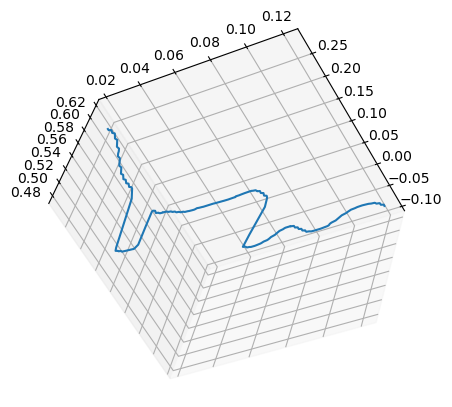

In [4]:
scale = 0.001

udder_shp = udder.get_shape()
line_vals = wu.udder_line(udder, udder_shp, new_kp["rf"], new_kp["lf"])
line_vals_xy = wu.derotate_points(new_kp["rf"], new_kp["lf"], line_vals[:, :2])
line_vals2 = np.column_stack((line_vals_xy[:, 0],line_vals_xy[:, 1], line_vals[:, 2]))
line_vals2 = line_vals2[~np.isnan(line_vals2[:, 2])]

line_vals2[:, 2] = line_vals2[:, 2]*scale

line_vals3 = points_toworld(line_vals2)
fig = plt.figure()
ax = plt.figure().add_subplot(projection='3d')

# Plot defining corner points
ax.plot(line_vals3[:, 0], line_vals3[:, 1], line_vals3[:, 2])
ax.view_init(elev=-50, azim=45, roll=-20)

In [31]:
scale = 0.001
img = udder.img.copy().astype(float)
img[img ==0] = np.nan
kernel = Gaussian2DKernel(x_stddev=1)
udder_conv = convolve(img, kernel)
udder_conv[np.isnan(udder_conv)] = 0

masked_udder =  udder.get_mask() * udder_conv 
rows, cols = np.nonzero(masked_udder)
values = masked_udder[rows, cols]
udder_points = np.column_stack((np.transpose(cols), np.transpose(rows), np.transpose(values))).astype(float)
udder_points[:, 2] = udder_points[:, 2] *scale
pts = points_toworld(udder_points)

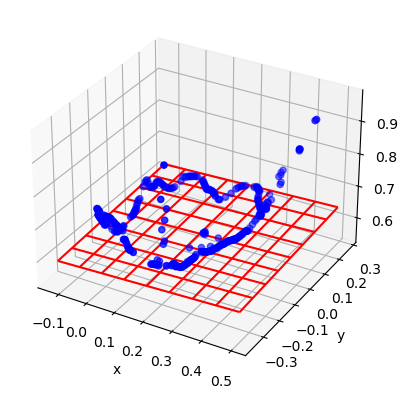

In [53]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.linalg import lstsq

segment = np.round([[coord[1] * udder.size[0], coord[0]* udder.size[1]] for coord in udder.get_segment()]).astype(int)
cols = segment[:, 1]
rows = segment[:, 0]
values = udder_conv[rows, cols]*scale
segment_points = np.column_stack((np.transpose(cols), np.transpose(rows), np.transpose(values))).astype(float)
sgpts = points_toworld(segment_points)
zmean = np.mean(sgpts[:,2])
zstd = np.std(sgpts[:, 2])

X = np.column_stack((np.ones((len(sgpts), 1)), sgpts[:, :2]))
z = np.transpose(sgpts[:, 2])

b = np.matrix(z).T
A = np.matrix(X)
fit, residual, rnk, s = lstsq(A, b)

xs = sgpts[:, 0]
ys = sgpts[:, 1]
zs = sgpts[:, 2]


plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b')

# plot plane
xlims = np.sort(xlim)
ylims = np.sort(ylim)
x = np.linspace(xlims[0], xlims[1], 9)
y = np.linspace(ylims[0], ylims[1], 9)

X,Y = np.meshgrid(x,y)
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[1] * X[r,c] + fit[2] * Y[r,c] + fit[0]
ax.plot_wireframe(X,Y,Z, color='r')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [107]:
import shapely
sgpts2 = sgpts.copy()
sgpts2[:, 2] = fit[1] * sgpts[:,0] + fit[2] * sgpts[:,1] + fit[0]
poly= shapely.Polygon(np.column_stack((sgpts2[:, 1], sgpts2[:, 0])))

x = np.linspace(np.min(sgpts2[:, 0]), np.max(sgpts2[:, 0]), 100)
y = np.linspace(np.min(sgpts2[:, 1]), np.max(sgpts2[:, 1]), 100)

X,Y = np.meshgrid(x,y)
points = np.column_stack((X.reshape((100*100, 1)), Y.reshape((100*100, 1))))

points_in = []
for point in points:
    loc = shapely.Point((point[1], point[0]))
    if poly.contains(loc):
        pred = fit[1] * point[0] + fit[2] * point[1] + fit[0]
        points_in.append([point[0], point[1], pred[0]])
        
new_points = np.array(points_in)
new_points2 = new_points.copy()
new_points2[:, 2] = 0
new_points3 = np.append(new_points, new_points2, axis= 0)

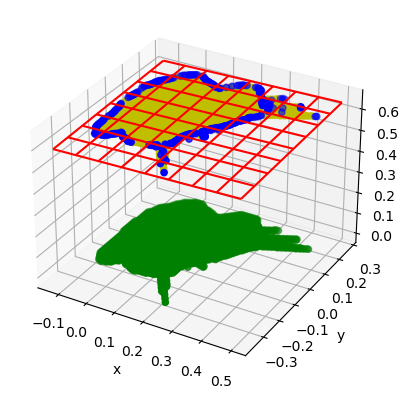

In [118]:

xs2 = new_points[:, 0]
ys2 = new_points[:, 1]
zs2 = new_points[:, 2]
zs3 = zs2.copy()
zs3[:] = 0

plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b')
ax.scatter(xs2, ys2, zs2, color='y')
ax.scatter(xs2, ys2, zs3, color='g')

# plot plane
xlims = np.sort(xlim)
ylims = np.sort(ylim)
x = np.linspace(xlims[0], xlims[1], 9)
y = np.linspace(ylims[0], ylims[1], 9)

X,Y = np.meshgrid(x,y)
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[1] * X[r,c] + fit[2] * Y[r,c] + fit[0]
ax.plot_wireframe(X,Y,Z, color='r')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()